In [1]:
# using PyPlot
# include("acoustic_solver.jl")
# include("barycenter.jl")

# using Distributed
# using SharedArrays
# addprocs(11);

In [20]:
@everywhere include("inverse_prob.jl")

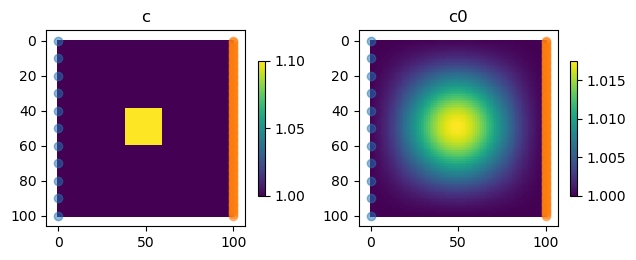

In [51]:
@eval @everywhere begin
Nx = 101;
Ny = 101;
h = 0.01;

Fs = 500;
dt = 1/Fs
Nt = 1001;
t = range(0, length=Nt, step=dt)

source = source_ricker(5, 0.2, t)
source_position = zeros(11,2)
for i = 1:11
    source_position[i,:] = [10*(i-1)+1, 1]
end
source = repeat(source, 1, 11)

receiver_position = zeros(101,2)
for i = 1:101
    receiver_position[i,:] = [(i-1)*1+1,101]
end

c = ones(Nx, Ny)
rho = ones(Nx, Ny)
c[40:60,40:60] .= 1.1

c0 = ones(Nx, Ny)
rho0 = ones(Nx, Ny)
# c0[60:end,:] .= 1.1
c0 = imfilter(c, Kernel.gaussian(20));
cc = ones(Nx, Ny)
rhoc = ones(Nx, Ny)

pml_len = 20
pml_coef = 100
end
figure
subplot(121)
imshow(c); colorbar(shrink=0.3); title("c")
scatter(source_position[:,2].-1, source_position[:,1].-1, alpha=0.5)
scatter(receiver_position[:,2].-1, receiver_position[:,1].-1, alpha=0.5)
subplot(122)
imshow(c0); colorbar(shrink=0.3); title("c0")
scatter(source_position[:,2].-1, source_position[:,1].-1, alpha=0.5)
scatter(receiver_position[:,2].-1, receiver_position[:,1].-1, alpha=0.5)

tight_layout()

In [52]:
# @time data, u = acoustic_eq_solver(c, rho, Nx, Ny, Nt, h, dt, source, source_position, receiver_position; pml_len=10, pml_coef=100);
# @time data0, u0 = acoustic_eq_solver(c0, rho0, Nx, Ny, Nt, h, dt, source, source_position, receiver_position; pml_len=10, pml_coef=100);
# @time datac, uc = acoustic_eq_solver(cc, rhoc, Nx, Ny, Nt, h, dt, source, source_position, receiver_position; pml_len=10, pml_coef=100);

@time data, u = multi_solver_parallel(c, rho, Nx, Ny, Nt, h, dt, source, source_position, receiver_position; pml_len=10, pml_coef=100);

@time data0, u0 = multi_solver_parallel(c0, rho0, Nx, Ny, Nt, h, dt, source, source_position, receiver_position; pml_len=10, pml_coef=100);

# @time datac, uc = multi_solver_parallel(cc, rhoc, Nx, Ny, Nt, h, dt, source, source_position, receiver_position; pml_len=10, pml_coef=100);


  5.019893 seconds (5.57 k allocations: 244.766 KiB)
  5.092356 seconds (5.73 k allocations: 256.094 KiB)


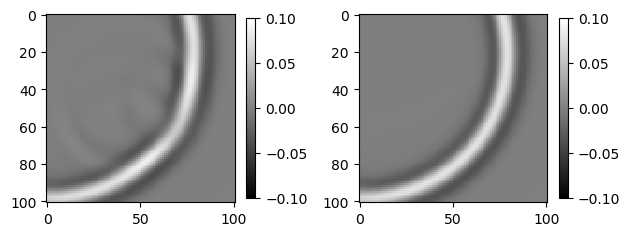

In [53]:
figure;
subplot(121); imshow(u[:,:,500,3],cmap=ColorMap("gray")); colorbar(shrink=0.4); clim(-0.1,0.1)
subplot(122);imshow(u0[:,:,500,3],cmap=ColorMap("gray")); colorbar(shrink=0.4); clim(-0.1,0.1)
tight_layout()

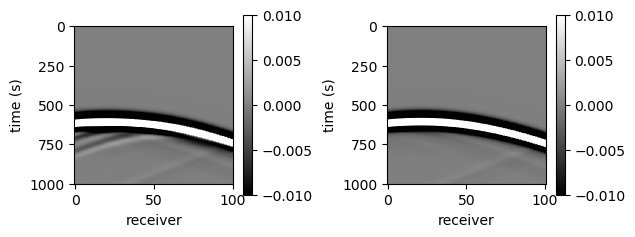

In [54]:
figure;
r_axis = 0:21
subplot(121); imshow(data[:,:,3],cmap=ColorMap("gray"), aspect=0.1); colorbar(shrink=0.4); clim([-0.01,0.01])
xlabel("receiver"); ylabel("time (s)")
subplot(122); imshow(data0[:,:,3],cmap=ColorMap("gray"), aspect=0.1); colorbar(shrink=0.4); clim([-0.01,0.01])
xlabel("receiver"); ylabel("time (s)")
tight_layout()

In [55]:
M = cost_matrix_1d(t, t; p=2)
@time adj_s, dd = adj_source_sinkhorn_parallel(data, data0, M; reg=5e-3, reg_m=1e2, iterMax=100, verbose=false);

 20.920309 seconds (6.48 k allocations: 25.705 MiB, 0.02% gc time)


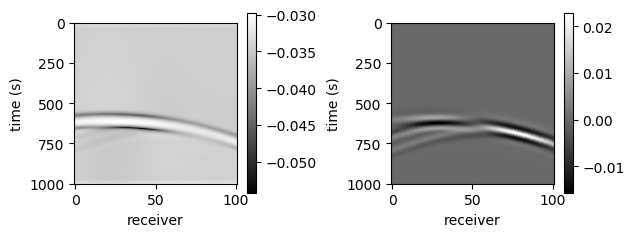

In [56]:
figure;
r_axis = 0:21
subplot(121); imshow(adj_s[:,:,3],cmap=ColorMap("gray"), aspect=0.1); colorbar(shrink=0.4);
xlabel("receiver"); ylabel("time (s)")
subplot(122); imshow(data0[:,:,3]-data[:,:,3],cmap=ColorMap("gray"), aspect=0.1); colorbar(shrink=0.4);
xlabel("receiver"); ylabel("time (s)")
tight_layout()

In [57]:
@time gg, dd = grad_sinkhorn_parallel(data, u, data0, c, rho, Nx, Ny, Nt, h, dt, source_position, receiver_position; pml_len=10, pml_coef=100, reg=1e-3, reg_m=1e2, iterMax=100, verbose=false);

 33.523626 seconds (11.82 k allocations: 8.398 GiB, 1.91% gc time)


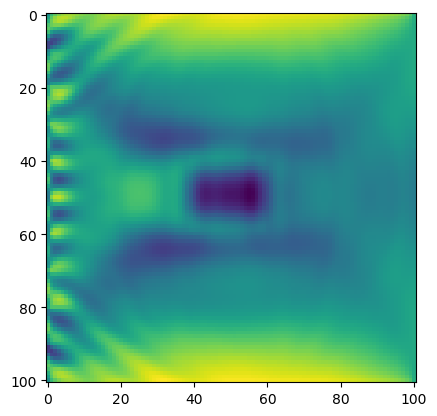

PyObject <matplotlib.image.AxesImage object at 0x7feee82da080>

In [58]:
imshow(gg)

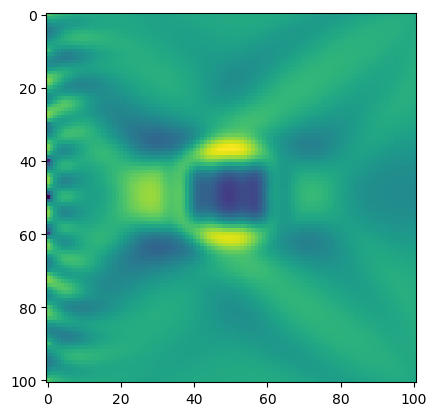

 22.714711 seconds (2.21 M allocations: 123.595 GiB, 19.64% gc time)


PyObject <matplotlib.image.AxesImage object at 0x7feee22d7668>

In [59]:
@time ggl = grad_l2(data, u, data0, c, rho, Nx, Ny, Nt, h, dt, source_position, receiver_position; pml_len=10, pml_coef=100);
imshow(ggl)

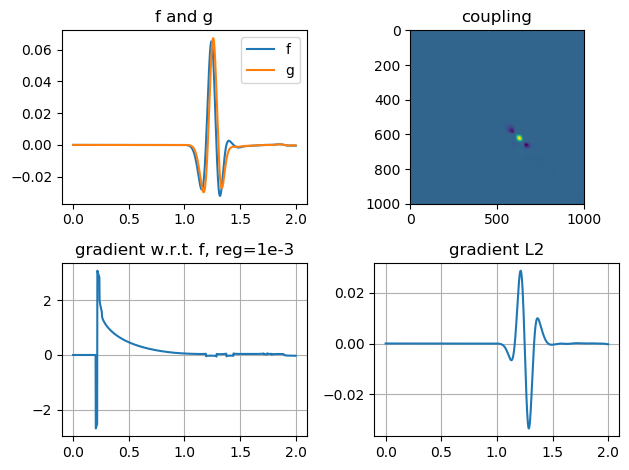

In [105]:
ind1 = 21
f = data[:,ind1]
g = data0[:,ind1]
M = cost_matrix_1d(t, t; p=2)

reg = 5e-3
reg_m = 1e4

TT,gg,dd = unbalanced_sinkhorn_1d_signal(f, g, M, reg, reg_m; iterMax=100, verbose=true)
figure;
subplot(221); plot(t,f,t,g); title("f and g"); legend(["f", "g"])
subplot(222); imshow(TT); title("coupling")
subplot(223); plot(t,gg); title("gradient w.r.t. f, reg=1e-3"); grid("on");
# ylim([-0.1,0.1])
subplot(224); plot(t,f-g); title("gradient L2"); grid("on")
tight_layout()

In [99]:
adj_source = zeros(Nt,101)
for ind = 1:101
#     f = data[:,ind]-datac[:,ind]
#     g = data0[:,ind]-datac[:,ind]
    f = data[:,ind]
    g = data0[:,ind]
    TT,adj_source[:,ind],dd = unbalanced_sinkhorn_1d_signal(f, g, M, reg, reg_m; iterMax=100, verbose=true)
end

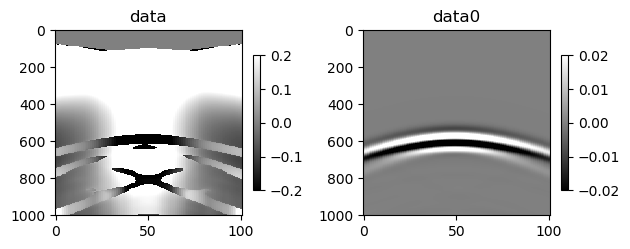

In [100]:
subplot(121)
imshow(adj_source, aspect=0.1, cmap="gray"); title("data"); colorbar(shrink=0.3); clim([-0.2,0.2])
subplot(122)
imshow(data-data0, aspect=0.1, cmap="gray"); title("data0"); colorbar(shrink=0.3); clim([-0.02,0.02])
tight_layout()

In [101]:
@time pw2 = backward_solver(c0, rho, Nx, Ny, Nt, h, dt, adj_source, source_position, receiver_position; pml_len=10, pml_coef=100);
@time pl2 = backward_solver(c0, rho, Nx, Ny, Nt, h, dt, data-data0, source_position, receiver_position; pml_len=10, pml_coef=100);

  8.127466 seconds (2.61 M allocations: 10.573 GiB, 17.22% gc time)
  6.507128 seconds (201.26 k allocations: 10.476 GiB, 21.26% gc time)


In [102]:
uu = 0 .* u;
uu[:,:,2:end-1,:] = (u[:,:,3:end,:] - 2*u[:,:,2:end-1,:] + u[:,:,1:end-2,:]) / (dt^2);
grad_w = uu[:,:,end:-1:1,:].*pw2
grad_w = sum(grad_w, dims=[3,4])
grad_w = grad_w[:,:,1,1]

uu = 0 .* u;
uu[:,:,2:end-1,:] = (u[:,:,3:end,:] - 2*u[:,:,2:end-1,:] + u[:,:,1:end-2,:]) / (dt^2);
grad_l2 = uu[:,:,end:-1:1,:].*pl2
grad_l2 = sum(grad_l2, dims=[3,4])
grad_l2 = grad_l2[:,:,1,1];

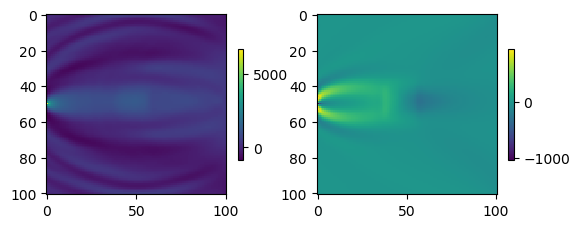

In [103]:
subplot(121)
imshow(grad_w); colorbar(shrink=0.3);
subplot(122)
imshow(grad_l2); colorbar(shrink=0.3);

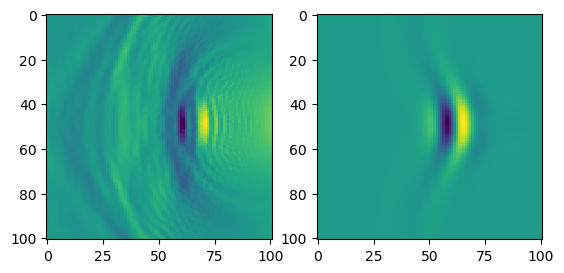

PyObject <matplotlib.image.AxesImage object at 0x142efb9d0>

In [104]:
indt = 600
subplot(121)
imshow(pw2[:,:,indt])
subplot(122)
imshow(pl2[:,:,indt])
